In [8]:
%tensorflow_version 2.x
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [9]:
###### hyper_Parameters ######
data_set_num = 9
start_from_index = 100
plt.figure(figsize=(10,6))
test_split = 0.2
future_prediction = 1
corr_w = 40
w = 30

<Figure size 720x432 with 0 Axes>

In [0]:
!wget https://github.com/srmt99/stock-market/blob/master/data/markets.npy?raw=true
!wget https://github.com/srmt99/stock-market/blob/master/data/stocks_1.npy?raw=true
!wget https://github.com/srmt99/stock-market/blob/master/data/stocks_2.npy?raw=true

stocks = []
for i in np.load("stocks_1.npy?raw=true",allow_pickle=True):
  stocks.append(i)
for i in np.load("stocks_2.npy?raw=true",allow_pickle=True):
  stocks.append(i)
stocks = np.array(stocks)
indices = np.load("markets.npy?raw=true",allow_pickle=True)

min_market_len = len(indices[0])
for i in indices[1:]:
  if len(i)<min_market_len:
    min_market_len = len(i)

for i in range(len(indices)):
  while len(indices[i])>min_market_len:
    indices[i] = np.delete(indices[i],0,0)

for i in range(len(stocks)):
  while len(stocks[i])>min_market_len:
    stocks[i] = np.delete(stocks[i],0,0)

indices = np.stack(indices,0)

122 43


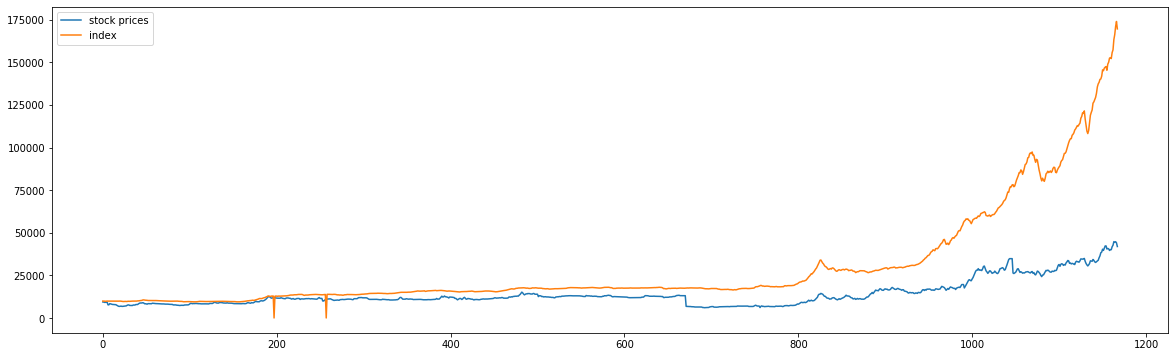

In [11]:
# ploting some random stock prices and indices
r1 = np.random.randint(len(stocks))
r2 = np.random.randint(len(indices))
print(r1,r2)
plt.figure(figsize=(20,6))
plt.plot(stocks[r1][:,1],label="stock prices")
plt.plot(indices[r2][:,1],label="index")
plt.legend()
plt.show()

In [0]:
def turn_to_windows(input,kernel,future):
    data = []
    labels = []
    for i in range(kernel,len(input)-future):
        data.append(input[i-kernel:i,:])
        labels.append(input[i:i+future,1])
    return np.array(data),np.array(labels).reshape(len(labels),future)

def turn_to_windows_multi(input,kernel):
  data = []
  for i in range(kernel,input.shape[1]-1):
        data.append(input[:,i-kernel:i])
  return np.array(data)

def smooth(input):
    output = []
    output.append(input[0])
    output.append(np.mean([input[0],input[1]]))
    for i in range(2,len(input)-2):
        mean = np.mean([input[i-2],input[i-1],input[i],input[i+1],input[i+2]])
        output.append(mean)
    output.append(np.mean([input[len(input)-2],input[len(input)-1]]))
    output.append(input[len(input)-1])
    return output

In [14]:
for count,stock in enumerate(stocks):
  records = []
  labels = []
  correlations = []
  x,y = turn_to_windows(stock,corr_w,1)
  for wc,window in enumerate(x[:,:,1]):
    corr = np.corrcoef(window,indices[: , min_market_len - len(x) - corr_w - 1 + wc : min_market_len - len(x) + wc -1 , 1])[1:,0]
    correlations.append( np.nan_to_num(corr) )
  correlations = np.array(correlations)
  x,y = turn_to_windows(stock,w,1)
  x2 = turn_to_windows_multi(indices[:,:,1],w)
  for wc in range(len(correlations),w,-1):
      record = np.zeros( (2*len(indices)+5,w) )
      record[:5,:] = np.transpose(x[wc + (len(x)-len(correlations)-1) ][:,1:]) # part 1
      record[5:5+len(indices)] = np.transpose(correlations[wc-w:wc]) # part 2
      record[5+len(indices):5+2*len(indices)] = x2[wc + (len(x2)-len(correlations)-1)] # part 3
      records.append(record)
      labels.append(y[wc + (len(x)-len(correlations)-1) ])
  np.save(f"records_{count}",np.array([records,labels]))
  print(f"{count}/{len(stocks)}")

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0/572
1/572
2/572
3/572
4/572
5/572
6/572
7/572
8/572
9/572
10/572
11/572
12/572
13/572
14/572
15/572
16/572
17/572
18/572
19/572
20/572
21/572
22/572
23/572
24/572
25/572
26/572
27/572
28/572
29/572
30/572
31/572
32/572
33/572
34/572
35/572
36/572
37/572
38/572
39/572
40/572
41/572
42/572
43/572
44/572
45/572
46/572
47/572
48/572
49/572
50/572
51/572
52/572
53/572
54/572
55/572
56/572
57/572
58/572
59/572
60/572
61/572
62/572
63/572
64/572
65/572
66/572
67/572
68/572
69/572
70/572
71/572
72/572
73/572
74/572
75/572
76/572
77/572
78/572
79/572
80/572
81/572
82/572
83/572
84/572
85/572
86/572
87/572
88/572
89/572
90/572
91/572
92/572
93/572
94/572
95/572
96/572
97/572
98/572
99/572
100/572
101/572
102/572
103/572
104/572
105/572
106/572
107/572
108/572
109/572
110/572
111/572
112/572
113/572
114/572
115/572
116/572
117/572
118/572
119/572
120/572
121/572
122/572
123/572
124/572
125/572
126/572
127/572
128/572
129/572
130/572
131/572
132/572
133/572
134/572
135/572
136/572
137/572
138/57

In [0]:
train = []
labels = []
for count,filename in enumerate(glob.glob("records_*.npy")):
  x,y = np.load(filename,allow_pickle=True)
  for i in x:
    train.append(i)
  for i in y:
    labels.append(i[0])
  if count == 30:
    break

train = np.array(train)
labels = np.array(labels)

In [0]:
train_mean = np.mean(train,(0,2)).reshape(1,105,1)
train_std = np.std(train,(0,2)).reshape(1,105,1)
labels_mean = np.mean(labels)
labels_std = np.std(labels)

train = (train - train_mean) / train_std
labels = (labels - labels_mean) / labels_std

test_size = np.floor(test_split*len(train))

train_set = tf.data.Dataset.from_tensor_slices((train,labels))
train_set = train_set.shuffle(10000)
test_set = train_set.take(test_size).batch(256)
train_set = train_set.skip(test_size)
train_set = train_set.batch(256)

In [20]:
# from here on , a (very!) simple modle is used to see if the dataset works
model = keras.Sequential()
model.add(keras.layers.LSTM(30,input_shape = train[0].shape,activation = "relu"))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Dense(1))
model.compile(optimizer="adam",loss="mae")
hist = model.fit(train_set,epochs=10)

Train for 104 steps
Epoch 1/10
104/104 [==============================] - 10s 97ms/step - loss: 0.5988
Epoch 2/10
104/104 [==============================] - 9s 91ms/step - loss: 0.5841
Epoch 3/10
104/104 [==============================] - 10s 92ms/step - loss: 0.5777
Epoch 4/10
104/104 [==============================] - 10s 92ms/step - loss: 0.5785
Epoch 5/10
104/104 [==============================] - 10s 92ms/step - loss: 0.5787
Epoch 6/10
104/104 [==============================] - 10s 93ms/step - loss: 0.5767
Epoch 7/10
104/104 [==============================] - 10s 92ms/step - loss: 0.5760
Epoch 8/10
104/104 [==============================] - 10s 95ms/step - loss: 0.5728
Epoch 9/10
104/104 [==============================] - 10s 93ms/step - loss: 0.5741
Epoch 10/10
104/104 [==============================] - 10s 93ms/step - loss: 0.5710


In [22]:
model.predict(train[0].reshape(1,105,30)),labels[0]

(array([[0.43883574]], dtype=float32), 4834.0)